pybullet build time: Feb  1 2023 20:12:59
2023-08-25 16:11:01.995555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 16:11:02.082486: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 16:11:02.084637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/baha/anaconda3/envs/gym-env/lib/pyt

robotiqGymEnv __init__
startThreads creating 1 threads.
starting thread 0
robot base reset
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Graphics (RKL GT1)
GL_VERSION=4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Graphics (RKL GT1)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL

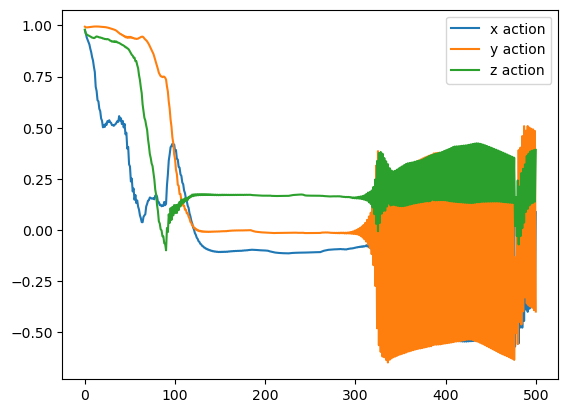

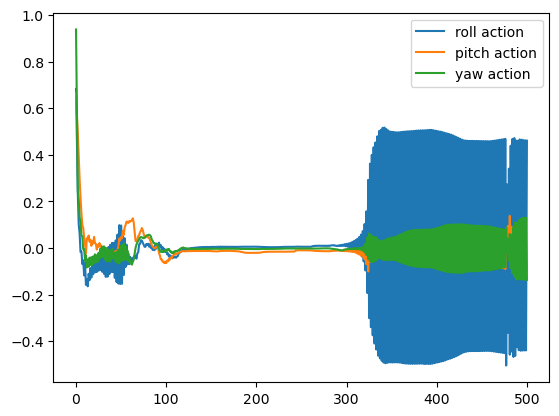

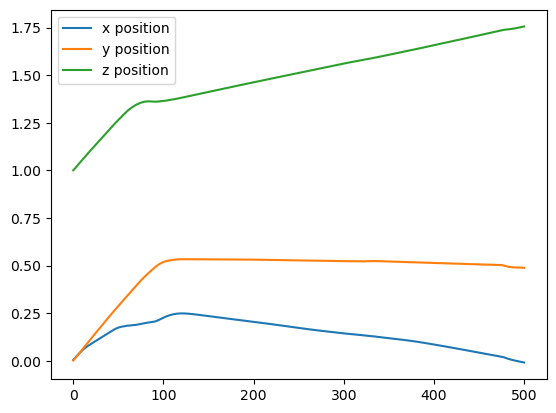

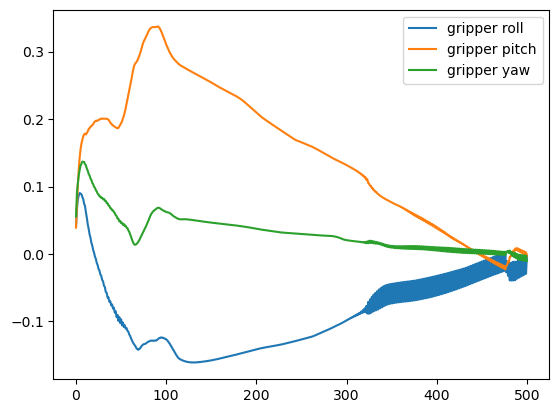

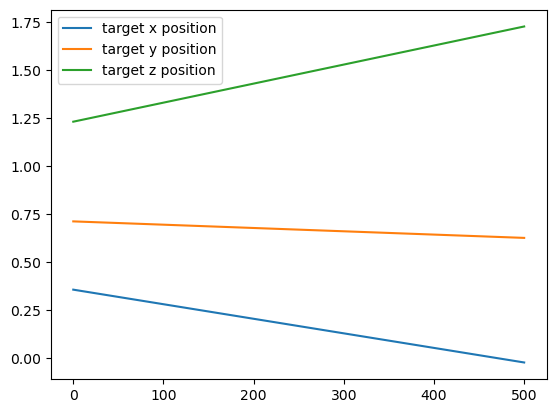

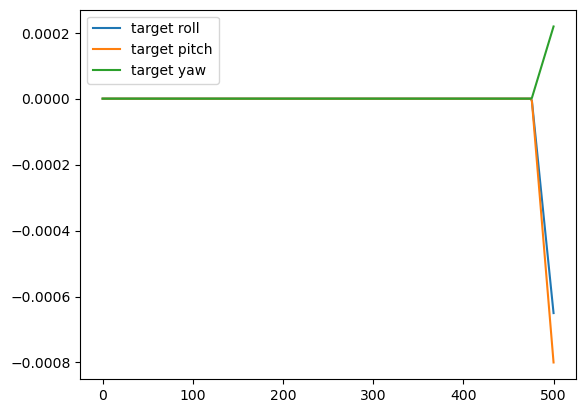

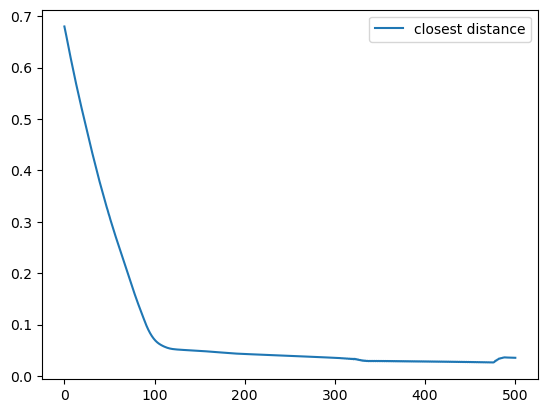

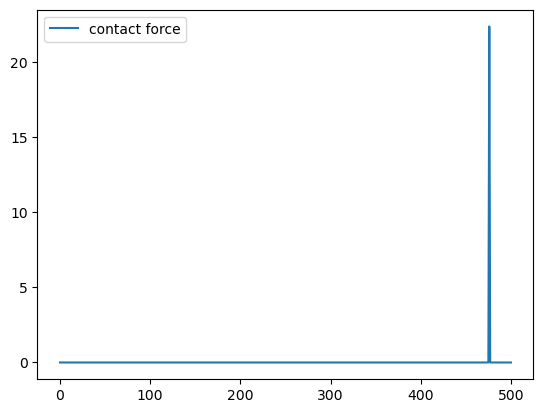

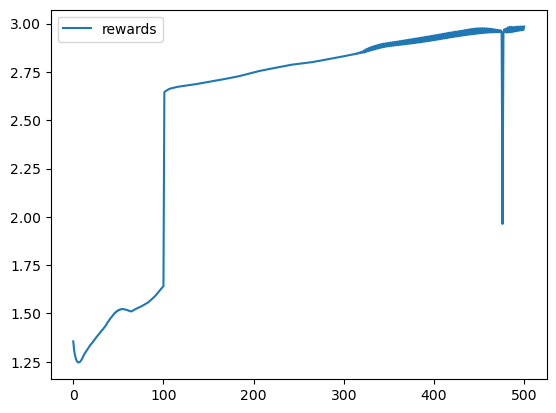

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
# from robotiqGymEnv import robotiqGymEnv
from newenv import robotiqGymEnv
import numpy as np

def load_model(file_path):
    """
    Load the model from the given file path
    """
    return SAC.load(file_path)

def extract_data(env, model, obs, steps):
    """
    Run the model prediction and extract data into arrays
    """
    position_action_data = []
    angle_action_data = []
    gripper_position_data = []
    gripper_angle_data = []
    target_position_data = []
    target_angle_data = []
    closest_point_data = []
    contact_force_data = []
    rewards_data = []
    done = False

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)

        base_pos, base_orientation = p.getBasePositionAndOrientation(env._robotiq.robotiq_uid)
        target_pos, target_orientation = p.getBasePositionAndOrientation(env.blockUid)

        gripper_angle = p.getEulerFromQuaternion(base_orientation)
        target_angle = p.getEulerFromQuaternion(target_orientation)

        position_action_data.append(action[0:3])
        angle_action_data.append(action[3:6])
        gripper_position_data.append(base_pos)
        gripper_angle_data.append(gripper_angle)
        target_position_data.append(target_pos)
        target_angle_data.append(target_angle)
        closest_point_data.append(p.getClosestPoints(env._robotiq.robotiq_uid, env.blockUid, 100, -1, -1)[0][8])
        contact_force_data.append(env._contactinfo()[4])
        rewards_data.append(rewards)
        
    return position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, target_position_data, target_angle_data, closest_point_data, contact_force_data, rewards_data

def plot_data(data, labels):
    """
    Plot the data using matplotlib
    """
    plt.figure()
    for d, label in zip(data, labels):
        plt.plot(d, label=label)
        plt.legend()

def main():
    """
    Main function to run the program
    """
    model_file = "models/20230316-03:42PM_SAC_M10000_0.04_39/best_model.zip"
    model = load_model(model_file)

    with robotiqGymEnv(records=False, renders=True) as env:
        obs = env.reset()
        # obs = [ 7.8762039e-11, -1.3363775e-10,  1.0000000e+00,
        #         7.5981269e-08, -2.6457928e-07,  3.2617684e-04,
        #         2.2676723e-08,  4.3184734e-08, -2.4198689e-08,
        #        -1.8782738e-06,  5.9628837e-05, -7.8282371e-02,
        #         2.2337140e-01,  7.0342982e-01,  8.2052636e-01,
        #         0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
        #         2.2337140e-01,  7.0342982e-01, -1.7947362e-01,
        #        -7.5981269e-08,  2.6457928e-07, -3.2617684e-04,
        #         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        #         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        #        -2.2676723e-08, -4.3184734e-08,  2.4198689e-08,
        #         1.8782738e-06, -5.9628837e-05,  7.8282371e-02,
        #        -9.8500714e-02, -5.5171615e-01,  1.1937499e-01]
        steps = range(500) # define the number of steps here
        position_action_data, angle_action_data, gripper_position_data, gripper_angle_data, target_position_data, target_angle_data, closest_point_data, contact_force_data, rewards_data = extract_data(env, model, obs, steps)


    plot_data(zip(*position_action_data), ["x action", "y action", "z action"])
    plot_data(zip(*angle_action_data), ["roll action", "pitch action", "yaw action"])
    plot_data(zip(*gripper_position_data), ["x position", "y position", "z position"])
    plot_data(zip(*gripper_angle_data), ["gripper roll", "gripper pitch", "gripper yaw"])
    plot_data(zip(*target_position_data), ["target x position", "target y position", "target z position"])
    plot_data(zip(*target_angle_data), ["target roll", "target pitch", "target yaw"])
    plot_data([closest_point_data], ["closest distance"])
    plot_data([contact_force_data], ["contact force"])
    plot_data([rewards_data], ["rewards"])
    gripper_position_data = np.array(gripper_position_data)
    gripper_final_position = np.mean(gripper_position_data[-100:, :], axis=0)
    target_position_data = np.array(target_position_data)
    target_final_position = np.mean(target_position_data[-100:, :], axis=0)
    print("gripper final position: ", gripper_final_position)
    print("target final position: ", target_final_position)
    D = 2628.9
    sat = 476.6
    robot_gripper_pose = [gripper_final_position[1]*1000, gripper_final_position[0]*1000, gripper_final_position[2]*1000]
    robot_sat_pose = [D - sat - target_final_position[1]*1000 - 100, - target_final_position[0]*1000, target_final_position[2]*1000 + 30]
    print("robot gripper pose: ", robot_gripper_pose)
    print("robot sat pose: ", robot_sat_pose)


if __name__ == "__main__":
    main()
